# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [42]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras import regularizers
from math import floor
#from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython', '/home/rgadea/lmfit-py/']


## Vamos introducir los datos de petalo preprocesados en matlab


In [43]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_julio_2018/conjunto_entrenamiento_julio_2018_ring1y2_fil1.mat')
conjunto_datos= datos_matlab.get('photodefbox2_todoA')

## Network parameters:

In [44]:
use_regularizer = True
my_regularizer = None
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

datos_matlab_encoder1 = hdf5storage.loadmat('../redes_compresoras/resultadoscompresores_1_medio_export.mat')
encoder_weights= datos_matlab_encoder1.get('encoder_weights')
encoder_biases= datos_matlab_encoder1.get('encoder_biases')
decoder_weights= datos_matlab_encoder1.get('decoder_weights')
decoder_biases= datos_matlab_encoder1.get('decoder_biases')
Encoder_weights=encoder_weights.transpose()
Encoder_biases=encoder_biases.transpose()
Decoder_weights=decoder_weights.transpose()
Decoder_biases=decoder_biases.transpose()
#Encoder_biases[0]

In [45]:
    
encoding_dim = 240  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# input image dimensions
img_rows, img_cols = 16, 30
# this is our input placeholder
input_img = Input(shape=(480,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='sigmoid',use_bias=True, weights=[Encoder_weights,Encoder_biases[0]] )(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(480, activation='sigmoid',use_bias=True, weights=[Decoder_weights,Decoder_biases[0]] )(encoded)

# this model maps an input to its reconstruction

autoencoder=Sequential([
    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001),input_shape=(480,)),
    Activation('sigmoid'),
    Dense(480),
    Activation('sigmoid'),
])


autoencoder_matlab = Model(input_img, decoded)
# autoencoder_matlab.get_weights()
# "autoencoder_matlab.set_weights(encoder_weights,encoder_biases,decoder_weights,decoder_biases)

## Prepare data into training and test set.

In [46]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=60
val_size=20
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]





Y_train=conjunto_datos[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

73588
conjunto_datos shape: (73588, 480)
44152
14717
14719


In [47]:
X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows,1)
X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows,1)


input_shape = (img_cols, img_rows,1)
#input_shape=input_shape.astype('int32')

In [48]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (44152, 30, 16, 1)
44152 train samples
14717 validation samples
14719 test samples


Display 20 random training images using image

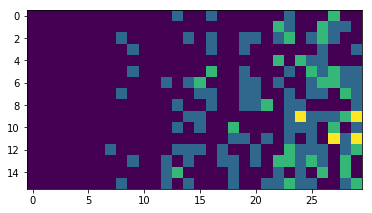

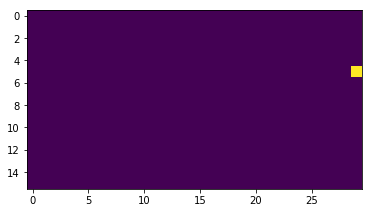

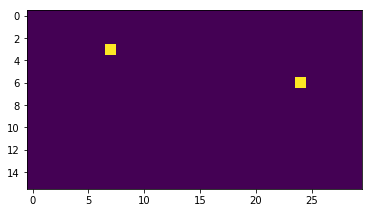

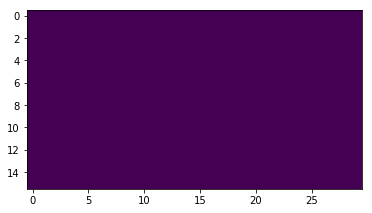

In [49]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [16, 30]), cmap='viridis')
    plt.show()

Vamos a generar las matrices de datos para la red neuronal 

In [50]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(44152, 480)
(14719, 480)


Vamos a escalar entre 0 y 1

In [51]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
# min_max_scaler = preprocessing.RobustScaler().fit(x_train)
x_train_min_max = min_max_scaler.transform(x_train)
x_test_min_max = min_max_scaler.transform(x_test)
#min_max_scaler.data_max_

## Build the CNN. 

In [52]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder_matlab.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder_matlab.compile(optimizer='sgd', loss='mse')
autoencoder.compile(optimizer='sgd', loss='mse')


Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [53]:
#tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/{}".format(time()))
#autoencoder.fit(x_train_min_max, x_train_min_max,
#                epochs=1500,
#                batch_size=500,
#                shuffle=False,
#                callbacks=[tensorboard],
#                validation_data=(x_test_min_max, x_test_min_max))



In [54]:
autoencoder_matlab.evaluate(x=x_test_min_max,y=x_test_min_max)

14719/14719 [==============================] - 1s 50us/step


0.00011545068416479888

In [56]:
# encode and decode some images
# note that we take them from the *test* set
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
encoded_imgs = encoder.predict(x_test_min_max)
decoded_imgs_scaled_dot= sigmoid(np.dot(encoded_imgs, Decoder_weights) + Decoder_biases[0])
decoded_imgs_scaled = autoencoder_matlab.predict(x_test_min_max)
decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#x_test_min_max[3928]

In [ ]:
#x_test[3928]

In [ ]:
#x_test_min_max[3929]

In [59]:
decoded_imgs_scaled[3928]

array([2.34294636e-03, 3.57693247e-03, 7.64102268e-04, 2.03834171e-03,
       1.13868923e-03, 4.17855947e-04, 1.37818817e-04, 5.38304957e-05,
       9.86916129e-04, 2.96366517e-04, 1.95944114e-04, 5.88856754e-04,
       1.64992444e-03, 5.63045731e-04, 2.37804590e-04, 7.67004793e-04,
       2.56806705e-03, 1.49124733e-03, 7.12021079e-04, 2.98726722e-04,
       1.07939658e-03, 7.48361635e-04, 3.51342285e-04, 1.42404845e-03,
       3.43230064e-03, 8.75418482e-04, 2.21970622e-04, 1.28932216e-03,
       3.25871719e-04, 1.84557011e-05, 3.20413703e-04, 6.10478281e-04,
       1.83516613e-03, 7.23026460e-04, 1.12588773e-03, 2.53940001e-03,
       4.27411916e-03, 3.67758505e-04, 1.39443277e-04, 2.84705457e-04,
       1.27742242e-04, 6.04224566e-04, 8.56337894e-04, 4.03802114e-05,
       7.39270617e-05, 2.18393179e-04, 1.38667843e-03, 9.65229236e-04,
       4.61816136e-03, 1.75883051e-03, 1.04574196e-03, 6.73511415e-04,
       2.63357698e-03, 7.56457739e-04, 5.97113918e-04, 1.37056166e-03,
      

In [58]:
decoded_imgs_scaled_dot[3928]

array([2.34294619e-03, 3.57693422e-03, 7.64102090e-04, 2.03834080e-03,
       1.13868957e-03, 4.17856129e-04, 1.37818789e-04, 5.38304570e-05,
       9.86916199e-04, 2.96366611e-04, 1.95944256e-04, 5.88856662e-04,
       1.64992452e-03, 5.63045943e-04, 2.37804576e-04, 7.67005027e-04,
       2.56806798e-03, 1.49124746e-03, 7.12020887e-04, 2.98726587e-04,
       1.07939667e-03, 7.48361496e-04, 3.51342299e-04, 1.42404874e-03,
       3.43230193e-03, 8.75418910e-04, 2.21970573e-04, 1.28932216e-03,
       3.25871920e-04, 1.84557123e-05, 3.20413865e-04, 6.10478373e-04,
       1.83516729e-03, 7.23025862e-04, 1.12588850e-03, 2.53939884e-03,
       4.27412223e-03, 3.67758486e-04, 1.39443302e-04, 2.84705567e-04,
       1.27742278e-04, 6.04224704e-04, 8.56337673e-04, 4.03802209e-05,
       7.39270321e-05, 2.18393286e-04, 1.38667887e-03, 9.65229053e-04,
       4.61816156e-03, 1.75883104e-03, 1.04574188e-03, 6.73511720e-04,
       2.63357593e-03, 7.56457349e-04, 5.97114172e-04, 1.37056128e-03,
      

In [57]:
decoded_imgs[3928]

array([2.65221524e+00, 1.55238867e+00, 1.42887115e-01, 8.52026880e-01,
       5.61373830e-01, 1.54606700e-01, 1.13424882e-01, 1.31346416e-02,
       1.08560777e+00, 3.08517545e-01, 2.80591995e-01, 7.28415787e-01,
       8.92609119e-01, 2.87716359e-01, 4.54206765e-02, 3.32113087e-01,
       8.47462177e-01, 8.69397163e-01, 5.04110932e-01, 1.05749257e-01,
       3.09786826e-01, 5.50794125e-01, 2.21696973e-01, 3.73100698e-01,
       1.32143581e+00, 1.48821145e-01, 1.11207284e-01, 1.03274703e+00,
       2.72102892e-01, 4.87230485e-03, 7.24134967e-02, 1.33084267e-01,
       1.54153943e+00, 9.90546271e-02, 8.45541716e-01, 4.54552621e-01,
       2.45334435e+00, 7.06096292e-02, 1.08486868e-01, 1.25555098e-01,
       6.50207996e-02, 1.84288487e-01, 2.62039393e-01, 2.08765678e-02,
       2.69094501e-02, 1.13346055e-01, 7.87633359e-01, 4.12152886e-01,
       1.83802819e+00, 2.77191687e+00, 1.53410339e+00, 9.84673619e-01,
       7.45302260e-01, 9.30443034e-02, 2.22126380e-01, 4.56397027e-01,
      

In [20]:
decoded_imgs[3929]

array([0.6713766 , 0.36930627, 0.10871807, 0.43521106, 0.41302523,
       0.12557063, 0.29162157, 0.06546187, 1.1557497 , 0.79680145,
       1.1233099 , 1.3583564 , 0.63135284, 0.58090985, 0.09438727,
       0.8492924 , 0.36185926, 0.2454733 , 0.28369525, 0.04697418,
       0.1931833 , 0.25680557, 0.2919936 , 0.18046768, 0.61835104,
       0.06809554, 0.2985293 , 1.0810868 , 0.7667435 , 0.04179215,
       0.19157796, 0.4029987 , 0.5967811 , 0.04694987, 0.33487388,
       0.10726599, 0.7708159 , 0.05726608, 0.22252575, 0.12977546,
       0.0625531 , 0.27807084, 0.43929604, 0.07424594, 0.03061841,
       0.4817381 , 0.5620063 , 0.7812166 , 0.45813203, 1.4583461 ,
       1.0294504 , 0.7643297 , 0.38297653, 0.0528539 , 0.1356224 ,
       0.3208498 , 0.12829693, 0.14660752, 0.4782808 , 0.20041272,
       0.6572327 , 0.02136513, 0.04538532, 0.55429065, 0.15809232,
       0.16239038, 0.1445912 , 0.25438154, 0.33741745, 0.18503755,
       0.37205103, 0.26232153, 0.10950758, 0.23181805, 0.87115

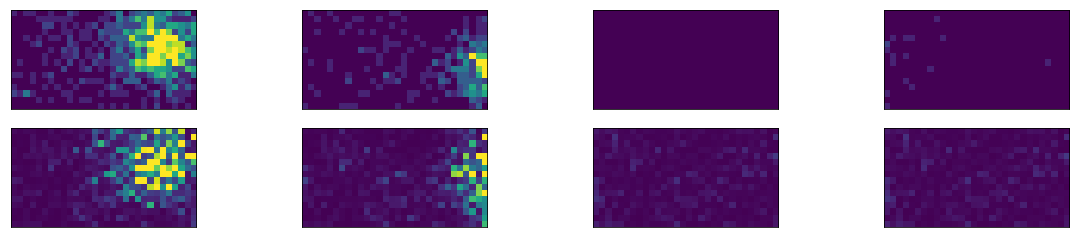

10132


In [41]:
n = 4  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(30, 16).transpose(),vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(30, 16).transpose(), vmin=0, vmax=10)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)



In [27]:
#print(error_prediction)